In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import t

In [72]:
eps = 0.01
alpha = 0.1
steps = 1000

In [73]:
def var(y_orig, y_pred):
    cost = 0
    cost += ((y_orig - y_pred) ** 2)
    cost = cost.sum()
    return cost

In [74]:
def mse(y_orig, y_pred):
    return var(y_orig, y_pred) / y_orig.shape[0]

In [134]:
def R_sq(y_orig, y_pred):
    n = len(y_orig)
    return (y_orig.var()*(n-1) - var(y_orig, y_pred)) / (y_orig.var()*(n-1))

In [138]:
def RSE(y, y_pred, df):
    n = len(y)
    return math.sqrt(var(y, y_pred)/(n - df))

In [76]:
def gradient_descent(X, y, w, b, alpha):
    n = len(X)
    y_pred = w * X + b
    error = y_pred - y
    # print(w, b)
    w_d = (1/n) * np.dot(X, error)
    b_d = (1/n) * np.sum(error)

    
    new_w = w - alpha * w_d
    new_b = b - alpha * b_d
    return new_w, new_b

In [77]:
def my_fit(X, y):
    w, b = (0.04, 7)
    std = X.std()
    mean = X.mean()
    X_scaled = (X - mean)/std

    w_history = []
    b_history = []
    
    for step in range(steps):
        w_new, b_new = gradient_descent(X_scaled, y, w, b, alpha)
        w_history.append(w_new)
        b_history.append(b_new)
        if abs(w_new - w) < eps and abs(b_new - b) < eps:
            break
        w, b = (w_new, b_new)

    w_orig = w/std
    b_orig = b - (w * mean)/std
    
    return (w_orig, b_orig, w_history, b_history)

In [78]:
def SE_b(X, y, y_pred, df):
    n = len(X)
    res_var = var(y, y_pred) / (n - df)
    print(math.sqrt(res_var))
    squared_error = X.var() * (n-1)
    mean = X.mean()
    
    
    return math.sqrt(res_var * (1/n + (mean**2)/squared_error))

def SE_w(X, y, y_pred, df):
    n = len(X)
    res_var = var(y, y_pred) / (n - df)
    squared_error = X.var() * (n-1)

    return math.sqrt(res_var / squared_error)

In [79]:
df = pd.read_csv('advertising.csv')

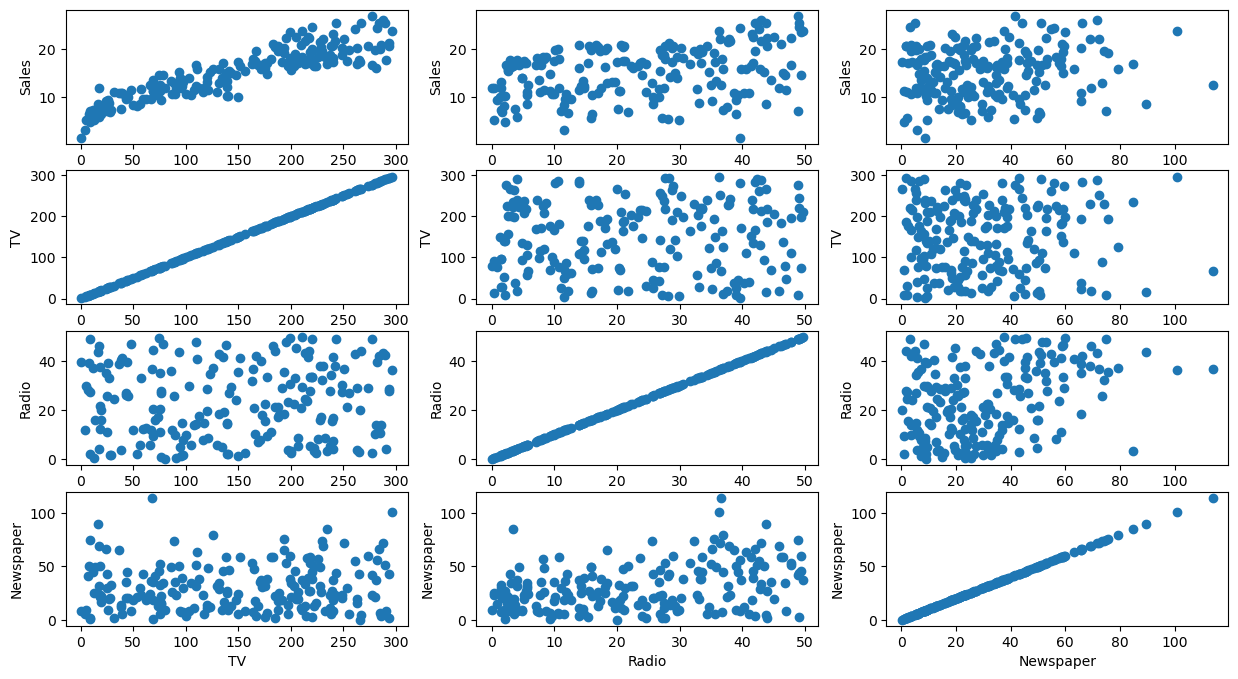

In [80]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 8))

rows = ['Sales', 'TV', 'Radio', 'Newspaper']
columns = ['TV', 'Radio', 'Newspaper']


for i in range(len(rows)):
    for j in range(len(columns)):
        axs[i, j].set(xlabel=columns[j], ylabel=rows[i])
        axs[i, j].scatter(x=df[columns[j]], y =df[rows[i]])

In [81]:
X = df['TV']
y = df['Sales']

w, b, w_hist, b_hist = my_fit(X, y)
y_pred = w * X + b

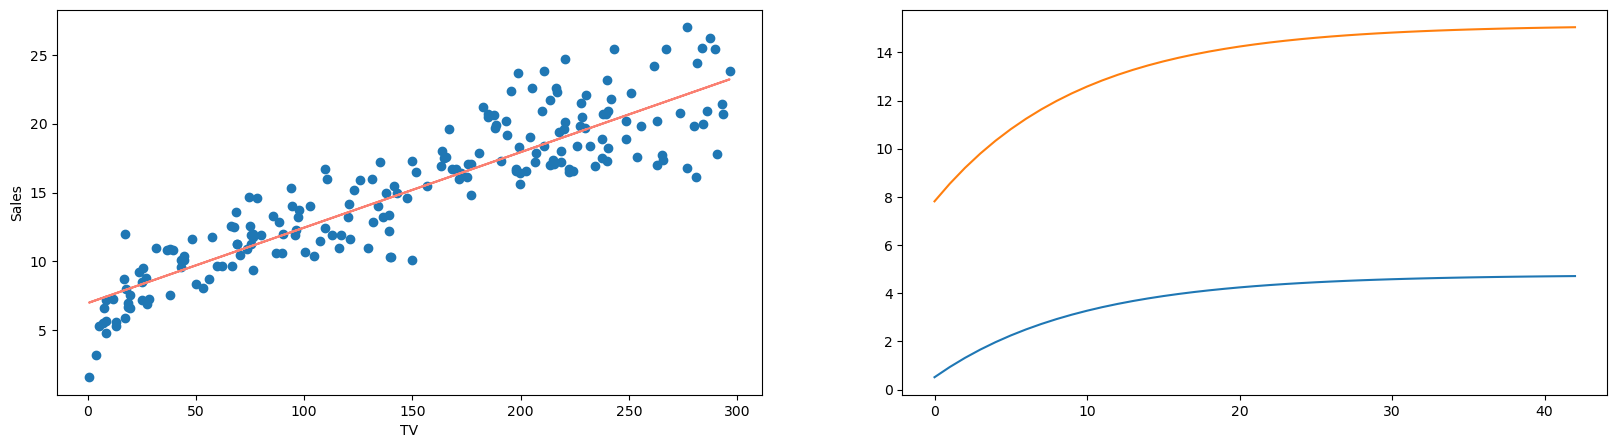

In [82]:
fig, axs = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
axs[0].set(xlabel='TV', ylabel='Sales')
axs[0].scatter(x=df['TV'], y=df['Sales'])
axs[0].plot(X, y_pred, color='salmon')



axs[1].plot(w_hist)
axs[1].plot(b_hist)


In [83]:
acc_df = pd.DataFrame(index=['w', 'b'], columns=['Coef', 'Std. error', 't-statistic', 'p-value'])

In [86]:
acc_df.loc['w', 'Coef'] = w
acc_df.loc['w', 'Std. error'] = SE_w(X, y, y_pred, 2)
acc_df.loc['w', 't-statistic'] = w/acc_df.loc['w', 'Std. error']
acc_df.loc['w', 'p-value'] = t.sf(acc_df.loc['w', 't-statistic'], len(X) - 2)

acc_df.loc['b', 'Coef'] = b
acc_df.loc['b', 'Std. error'] = SE_b(X, y, y_pred, 2)
acc_df.loc['b', 't-statistic'] = b/acc_df.loc['b', 'Std. error']
acc_df.loc['b', 'p-value'] = t.sf(acc_df.loc['b', 't-statistic'], len(X) - 2)

2.2985615446693606


In [88]:
acc_df

,Coef,Std. error,t-statistic,p-value
w,0.054791,0.001898,28.86951,0.0
b,6.976588,0.322949,21.602747,0.0


### Scikit-Learn

In [89]:
X_orig = df['TV'].values
X = [[i] for i in df['TV'].values]
y = df['Sales']

In [90]:
reg = LinearRegression().fit(X, y)

In [91]:
w = reg.coef_
b = reg.intercept_
y_pred = w * X_orig + b 
print(w[0], b)

0.05546477046955886 6.9748214882298925


In [96]:
acc_df = pd.DataFrame(index=['w', 'b'], columns=['Coef', 'Std. error', 't-statistic', 'p-value'])
acc_df.loc['w', 'Coef'] = w
acc_df.loc['w', 'Std. error'] = SE_w(X_orig, y, y_pred, 2)
acc_df.loc['w', 't-statistic'] = acc_df.loc['w', 'Coef']/acc_df.loc['w', 'Std. error']
acc_df.loc['w', 'p-value'] = 2 * t.sf(np.abs(acc_df.loc['w', 't-statistic']), len(X) - 2)

acc_df.loc['b', 'Coef'] = b
acc_df.loc['b', 'Std. error'] = SE_b(X_orig, y, y_pred, 2)
acc_df.loc['b', 't-statistic'] = acc_df.loc['b','Coef']/acc_df.loc['b', 'Std. error']
acc_df.loc['b', 'p-value'] = 2 * t.sf(np.abs(acc_df.loc['b', 't-statistic']), len(X) - 2)

2.2957457136214456


In [135]:
quant_df = pd.DataFrame(columns=['Quantity', 'Value'])
quant_df['Quantity'] = ['RSE', 'R^2']
quant_df = quant_df.set_index('Quantity')


In [139]:
quant_df.loc['R^2', 'Value'] = R_sq(y, y_pred)
quant_df.loc['RSE', 'Value'] = RSE(y, y_pred, 2)

In [140]:
quant_df

,Value
Quantity,
RSE,2.295746
R^2,0.812176


In [130]:
from sklearn.metrics import r2_score
r2_score(y, y_pred)

0.8121757029987414